 ## Time series Analysis on NSE Stock Data

This notebook is hosted online on Kaggle. You can get this notebook and dataset from [here](https://www.kaggle.com/chandankumarroy/time-series-analysis)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10,8)

import warnings
warnings.filterwarnings('ignore')

In [2]:
stock_df = pd.read_csv("../input/nse-stocks-data/FINAL_FROM_DF.csv")
stock_df.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
0,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,2017-06-28,202,INE144J01027
1,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,2017-06-28,7353,INE748C01020
2,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,2017-06-28,748,INE470A01017
3,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,2017-06-28,437,INE111B01023
4,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,2017-06-28,1866,INE650K01021


## Data Preprocessing

In [3]:
stock_df.columns

Index(['SYMBOL', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE',
       'TOTTRDQTY', 'TOTTRDVAL', 'TIMESTAMP', 'TOTALTRADES', 'ISIN'],
      dtype='object')

In [4]:
# convert TIMESTAMP to datetime instance
stock_df['TIMESTAMP'] = pd.to_datetime(stock_df.TIMESTAMP, dayfirst = True)
stock_df.set_index('TIMESTAMP', inplace = True)
stock_df['PER_DAILY_CHANGE'] = (stock_df.CLOSE - stock_df.OPEN)*100/stock_df.OPEN
stock_df.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES,ISIN,PER_DAILY_CHANGE
TIMESTAMP,,,,,,,,,,,,,
2017-06-28,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,202,INE144J01027,-2.513228
2017-06-28,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,7353,INE748C01020,10.975610
2017-06-28,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,748,INE470A01017,-1.180248
2017-06-28,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,437,INE111B01023,0.000000
2017-06-28,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,1866,INE650K01021,-1.583959


In [5]:
#Lets check how many different symbols are present in the dataset
unique_symb = stock_df['SYMBOL'].unique()
print("total number of unique symbols is ", len(unique_symb))

#let's print top 10 different symbols
unique_symb[:10]

total number of unique symbols is  2037


array(['20MICRONS', '3IINFOTECH', '3MINDIA', '63MOONS', '8KMILES',
       'A2ZINFRA', 'AARTIDRUGS', 'AARTIIND', 'AARVEEDEN', 'ABAN'],
      dtype=object)

In [6]:
# total number of datapoints
stock_df.shape

(846404, 13)

In [7]:
#say if we are interested in predicting prices of Banks only
bank_stock = stock_df[stock_df['SYMBOL'].str.contains("BANK")]
bank_stock.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES,ISIN,PER_DAILY_CHANGE
TIMESTAMP,,,,,,,,,,,,,
2017-06-28,ANDHRABANK,EQ,52.60,54.25,52.40,53.95,54.05,53.45,3191618,1.708973e+08,7202,INE434A01013,2.566540
2017-06-28,AXISBANK,EQ,493.80,500.35,490.05,492.00,496.45,492.85,12691859,6.260657e+09,76061,INE238A01034,-0.364520
2017-06-28,BANKBARODA,EQ,153.00,156.40,152.20,155.60,155.90,154.85,6999255,1.083748e+09,41604,INE028A01039,1.699346
2017-06-28,BANKBEES,EQ,2341.89,2355.72,2335.91,2354.88,2355.00,2347.31,8106,1.904236e+07,318,INF732E01078,0.554680
2017-06-28,BANKINDIA,EQ,132.00,137.65,131.35,136.75,136.55,133.55,4789755,6.463776e+08,22220,INE084A01016,3.598485


In [8]:
#We need to define the columns data we are interested in predicting,
# say we want to predict the closing price of all the companies
#lets plot a pivot table

stock_pivot = bank_stock.pivot_table(values = 'CLOSE', columns = 'SYMBOL', index = 'TIMESTAMP')
stock_pivot.head()

SYMBOL,ANDHRABANK,AUBANK,AXISBANK,BANKBARODA,BANKBEES,BANKINDIA,CORPBANK,DCBBANK,DENABANK,DHANBANK,...,MYSOREBANK,ORIENTBANK,RBLBANK,RELBANK,SOUTHBANK,SYNDIBANK,UCOBANK,UNIONBANK,VIJAYABANK,YESBANK
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2016-01-01,66.15,NaN,449.90,159.05,1713.47,117.35,43.45,82.10,41.05,22.05,...,427.30,144.25,NaN,1840.00,19.65,89.85,45.70,150.00,34.20,732.45
2016-01-04,63.80,NaN,438.40,151.20,1672.95,114.70,42.60,79.95,40.75,22.30,...,419.45,137.45,NaN,1805.70,19.55,86.50,44.60,144.65,33.85,705.75
2016-01-05,63.55,NaN,436.45,148.10,1668.14,113.90,42.55,79.95,40.50,22.30,...,420.10,136.60,NaN,1787.00,19.95,85.45,44.70,142.95,33.95,707.70
2016-01-06,63.15,NaN,430.70,148.70,1651.24,114.25,42.20,79.90,40.40,22.05,...,423.15,134.85,NaN,1787.07,20.05,85.40,44.55,143.65,33.90,703.85
2016-01-07,60.85,NaN,409.25,139.50,1619.80,109.05,41.00,76.10,39.45,20.35,...,420.75,127.15,NaN,1750.10,19.55,81.70,42.45,135.55,33.10,678.85


In [9]:
stock_pivot.shape

(495, 29)

In [10]:
#let's drop those columns in which there are missing values
stock_pivot.dropna(axis = 1, how = 'any', inplace = True)
stock_pivot.head()

SYMBOL,ANDHRABANK,AXISBANK,BANKBARODA,BANKBEES,BANKINDIA,CORPBANK,DCBBANK,DENABANK,DHANBANK,HDFCBANK,...,KOTAKBANK,KTKBANK,MAHABANK,ORIENTBANK,SOUTHBANK,SYNDIBANK,UCOBANK,UNIONBANK,VIJAYABANK,YESBANK
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2016-01-01,66.15,449.90,159.05,1713.47,117.35,43.45,82.10,41.05,22.05,1193.65,...,723.625,124.80,32.25,144.25,19.65,89.85,45.70,150.00,34.20,732.45
2016-01-04,63.80,438.40,151.20,1672.95,114.70,42.60,79.95,40.75,22.30,1070.50,...,705.300,120.90,31.70,137.45,19.55,86.50,44.60,144.65,33.85,705.75
2016-01-05,63.55,436.45,148.10,1668.14,113.90,42.55,79.95,40.50,22.30,1169.20,...,707.750,119.50,32.05,136.60,19.95,85.45,44.70,142.95,33.95,707.70
2016-01-06,63.15,430.70,148.70,1651.24,114.25,42.20,79.90,40.40,22.05,1067.10,...,703.600,118.65,31.85,134.85,20.05,85.40,44.55,143.65,33.90,703.85
2016-01-07,60.85,409.25,139.50,1619.80,109.05,41.00,76.10,39.45,20.35,1056.20,...,691.650,112.95,31.15,127.15,19.55,81.70,42.45,135.55,33.10,678.85


In [11]:
stock_pivot.shape

(495, 24)

In [12]:
#Randomly choose 5 columns and plot its value
# col = stock_pivot.columns[np.random.randint(0, len(stock_pivot.columns)+1, size = 5)]


Bank is =  CORPBANK


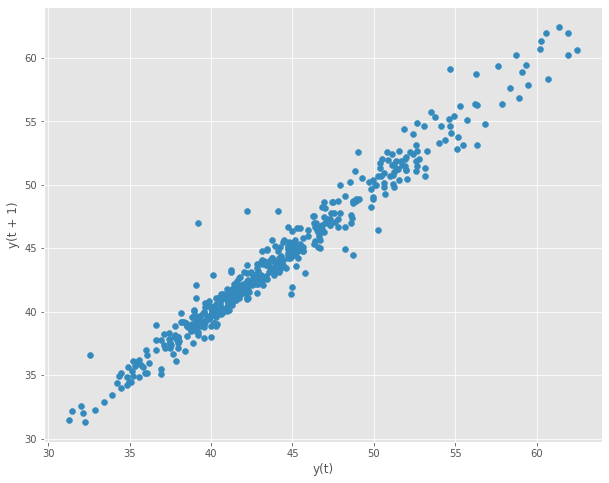

In [13]:
#most important thing in time series analysis is to have correlation between the values at different timestamp
#choose one bank at random and look for correlation using lag plot with lag value 1
np.random.seed(1)
bank = stock_pivot.columns.values[np.random.randint(0, len(stock_pivot.columns)+1)]
print("Bank is = ", bank)
pd.plotting.lag_plot(stock_pivot[bank])
plt.show()

As we can see in the above plot that there is strong correlation bewteen the datapoints. So, we are good to go with time series analysis on the above data

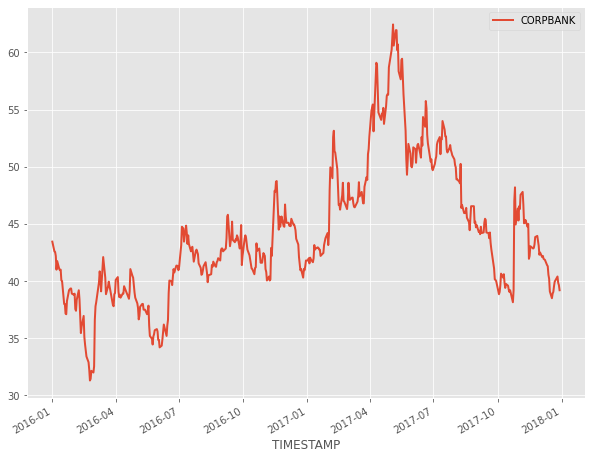

In [14]:
stock_pivot.plot(kind ='line', y = bank)
plt.show()

In [15]:
# #check for correlation using heatmap
# plt.figure(figsize = (14,14))
# sns.heatmap(stock_pivot.corr(method='pearson'),annot=True, linewidth = 1)

The most important thing in autocorrelation analysis is to know the appropriate lag value. we can manually do that. Let's do that.

In [16]:
# find appropriate lag value for the autocorrelation analysis
MAX_LAG = 30 #maximum lag value
corr = 0
lag = 1
for i in range(1, MAX_LAG):
    temp = np.abs(stock_pivot[bank].corr(stock_pivot[bank].shift(i)))
    if temp > corr:
        corr = temp
        lag = i

print("apprpriate lag value is ", lag)
    


apprpriate lag value is  1


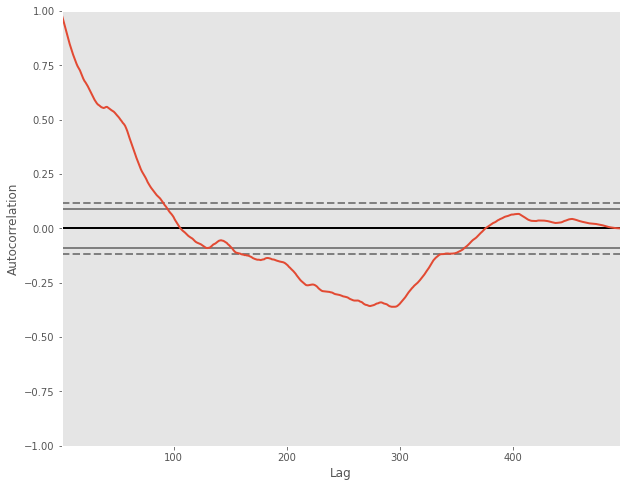

In [17]:
#Let's cross check our value using pandas autocorrelation plot
pd.plotting.autocorrelation_plot(stock_pivot[bank])
plt.show()

We can see in the above plot that the autocorrelation corresponding to lag value 1 is maximum

## Check for Trend and seasonality

__Note__ that we have assumed our model to be additive in general

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

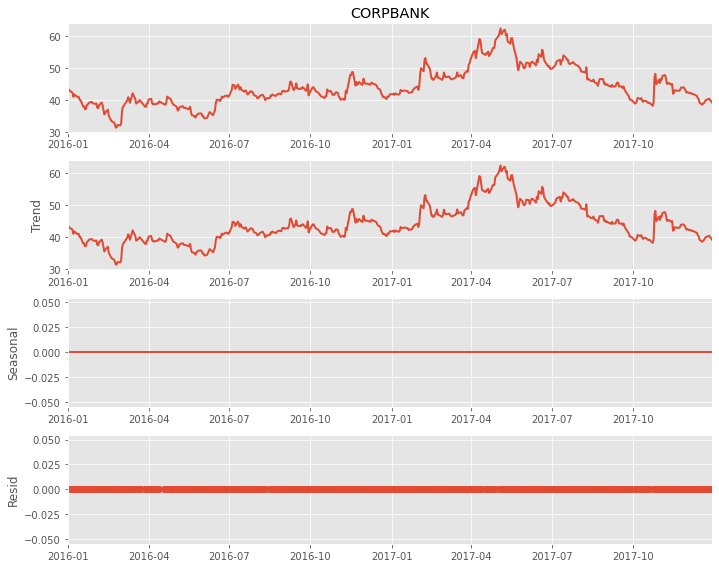

In [19]:
#seasonal decomposition using period of 1
decomposed = seasonal_decompose(stock_pivot[bank], model='additive', period = 1)

x = decomposed.plot()

Though our dataset does not exhibit trend and seasonality, But it's still a good practice to make model stationary by differencing

In [20]:
# remove seasonality and trend
df = stock_pivot.copy()
df['STATIONARY'] = df[bank].diff()
df.STATIONARY

TIMESTAMP
2016-01-01     NaN
2016-01-04   -0.85
2016-01-05   -0.05
2016-01-06   -0.35
2016-01-07   -1.20
              ... 
2017-12-22    0.40
2017-12-26    0.45
2017-12-27   -0.55
2017-12-28   -0.20
2017-12-29   -0.45
Name: STATIONARY, Length: 495, dtype: float64

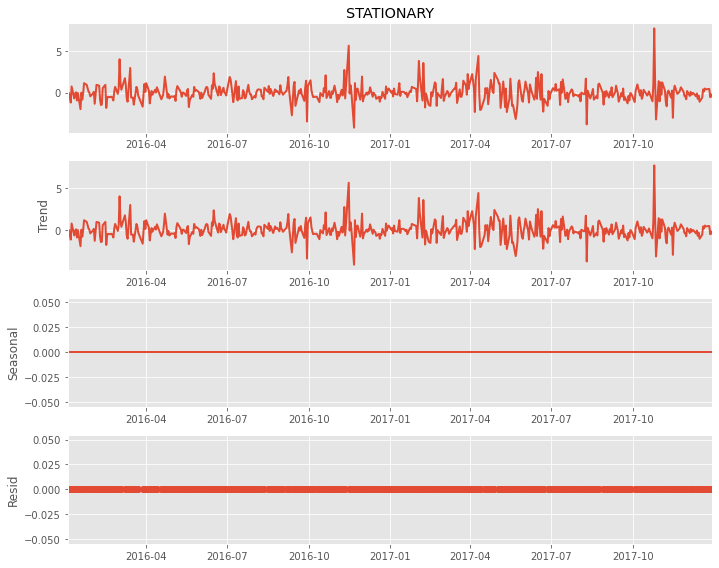

In [21]:
# Recheck for seasonality and trend
df.dropna(axis = 0, inplace = True)
decomposed = seasonal_decompose(df['STATIONARY'], model='additive', period = 1)
x = decomposed.plot()

## AR(1) model

In [22]:
#divide data in train and test
freq = 7
X = df['STATIONARY']
Y =  X.shift(1).dropna()
Y, X
train_size = int(len(X)*0.8)
# train, test = X[1: len(X)-freq], X[len(X)-freq : ]
# train.shape, test.shape
x_train, x_test = X[0:train_size], X[train_size:len(X)-1]
y_train, y_test = Y[0:train_size], Y[train_size:]
x_train.shape, y_train.shape

((395,), (395,))

In [23]:
#AR1 equation is given by
#x_t = ϕ_{t-1} + ϵ

#find ϕ using OLS (ordinary least square)
phi = np.dot(x_train.values,y_train.values.T)/np.dot(x_train, x_train.T)
print(phi)

1.0


In [24]:
#check the prediction over test data
pred = phi*x_test
pred

TIMESTAMP
2017-08-08   -0.15
2017-08-09    1.70
2017-08-10   -3.85
2017-08-11    0.25
2017-08-14   -0.70
              ... 
2017-12-21    0.50
2017-12-22    0.40
2017-12-26    0.45
2017-12-27   -0.55
2017-12-28   -0.20
Name: STATIONARY, Length: 98, dtype: float64

In [25]:
y_test

TIMESTAMP
2017-08-09   -0.15
2017-08-10    1.70
2017-08-11   -3.85
2017-08-14    0.25
2017-08-16   -0.70
              ... 
2017-12-22    0.50
2017-12-26    0.40
2017-12-27    0.45
2017-12-28   -0.55
2017-12-29   -0.20
Name: STATIONARY, Length: 98, dtype: float64

In [26]:
#finding mean square error
import sklearn.metrics as m
r2 =m.r2_score(y_test, pred)
print("R square is ", r2)

R square is  1.0


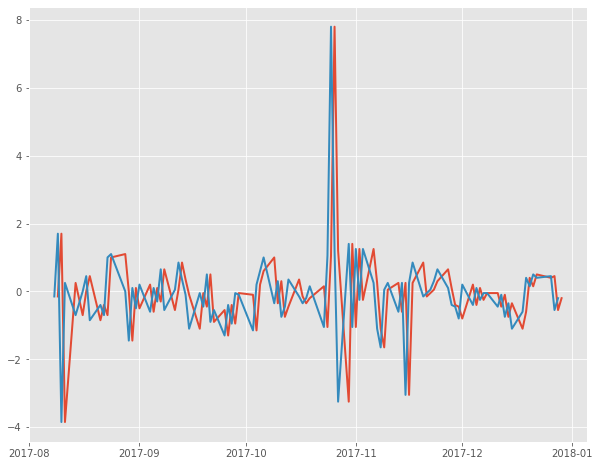

In [27]:
#let's plot the predicted vs test value
plt.plot(y_test)
plt.plot(pred)
plt.show()

As it can be seen in the above plot that we are nearly predicting the exact value as it should. it makes sense as we can see in the correlation plot that all the data points are perfectly cluttered along the diagonal.